<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/1ship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning

Machine learning tasks can be loosely grouped into three categories
1. Supervised Learning
1. Unsupervised Learning
1. Reinforcement Learning

In this course we will practice mostly supervised learning. In supervised learning we are given N data points.

$$Data=\{(x_1,y_1),\ldots,(x_N,y_N)\}$$ 

presumably generated (or sampled) by some __unknown__  function __y=f(x)__. Our goal basically is to __learn__ (an approximation of) __f(x)__. If we do it successfully then for any input __x__ we can compute __y=f(x)__. We type of supervised learning is __classification__. In this case __y__ belongs to a discrete set of classes _C_. For classification problem usually we assume that each pair $(x_i,y_i)$ was sampled from some __unknown__ probability distribution __p(y|x)__ and our task is to learn an approximation of __p(y|x)__.

In this lecure we give the first example of **supervised learning**. We are given a set of (image,label) pairs (CIFAR10)   where each image can be in one of the __ten__ classes: ship, horse, car...etc and so each label is a value between 0 and 9 denoting the class of image. For example an image with an associated label of 8 is that of a ship. 

Our goal is "learn" a probability function __p(y|x)__ which, given an input image, it gives us the probability that that image is a ship or not (you can use others).



## Logistic Regression

In this module we introduce Logistic Regression which can be regarded as the simplest neural network, a single "neuron". This type of network is sometime called a Perceptron, but the method used for learning is different from the way a Perceptron learns. 

As can be seen from the figure below the input is a vector of size _n_ and it feeds a single unit (a neuron or perceptron). To obtain the output we perform the **dot** product between the matrix **W** and the input **x** and the result is fed into some function (usually nonlinear) _f_

$$
\begin{align*}
z&=\sum_iw_i\cdot x_i+b\\
\hat{p}(y|x)&=f(z)
\end{align*}
$$

Since $z$ depends on $w$ and $b$ so does $\hat{p}$. The input and _f_ are known whereas _W_ and _b_ are parameters to be determined. Our goal is to find the _optimal_ _W_ and _b_ such that the output is as close as possible to the label associated with the input.
![title](https://github.com/hikmatfarhat-ndu/CSC645/blob/master/figures/perceptron.png?raw=1)


## Needed Packages
We need a few packages to help us in this module.
1. Tensorflow is needed just to retreive the data. We can always downloaded  
    from the web and read it but it is convenient to use tensorflow.
1.matplotlib is used for graphs. 
1. all matrix computation is done with numpy (or cupy). 
numpy is the de facto standard of matrix computation with python. cupy has almost the same interface but it uses NVIDIA cuda to perform the computation on the GPU. If you have access to a GPU ( like we have on Google colab) it is better to use cupy. If you are using Google colab go to Runtime->change runtime type and choose GPU

In [1]:
import cupy as np 
#import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## The data

The CIFAR10 data set contains 50000 images for trainning and 10000 for testing. Each image has dimension 32x32 pixels and each pixel has an RGB value. Also each image has an associated label from 0 to 9 describing what type of image it is. The keras function returns tensors of type numpy.ndarray.
After reading the data we print some of its properties and plot the first ten images.

In [2]:
(img_train,label_train),(img_test,label_test)=tf.keras.datasets.cifar10.load_data()
print(img_train.shape)
print(label_train.shape)
print(type(img_train))


(50000, 32, 32, 3)
(50000, 1)
<class 'numpy.ndarray'>


## Plotting the images

We plot the first ten images using matplotlib where the title on top is the corresponding label. As can be seen 9--> Truck, 1-->car, 8-->ship... etc


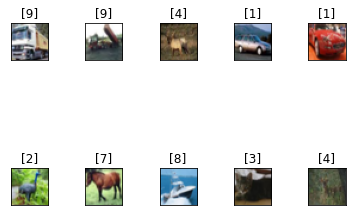

In [3]:
fig=plt.figure()
fig.tight_layout()
plt.subplots_adjust( wspace=1, hspace=1)

for i in range(1,11):
    img=img_train[i]    
    t=fig.add_subplot(2,5,i)
    t.set_title(str(label_train[i]))
    t.axes.get_xaxis().set_visible(False)
    t.axes.get_yaxis().set_visible(False)
    plt.imshow(img)


## Preprocessing the data

img_train is a tensor of shape (50000,32,32,3). This means we have 50000 images with of size 32x32 with RGB encoding. Since our logistic regression assumes the input is a vector we flatten the data. Also the return value from keras is of type numpy.ndarray it would cause a problem with cupy so we convert it to cupy array.
Finally, since the data is a row vector we convert it to a column vector by taking the transpose:  X.T is the transpose of X


In [4]:
img_train=np.array(img_train.reshape(50000,32*32*3)/255.)
img_test=np.array(img_test.reshape(10000,32*32*3)/255.)
label_train=np.array(label_train.reshape(50000,1))
label_test=np.array(label_test.reshape(10000,1))

print(img_train.shape)
print(type(img_train))
print(label_train.shape)


(50000, 3072)
<class 'cupy.core.core.ndarray'>
(50000, 1)


## Binary classification

In this exercise we would like to recognize if an image contains a ship (label=8) or not. We convert anything that is 8 to 1 and everything else to 0

In [5]:

feature=8
for i in range(label_train.shape[0]):
    if label_train[i]==feature:
        label_train[i]=1
    else:
        label_train[i]=0

for i in range(label_test.shape[0]):
    if label_test[i]==feature:
        label_test[i]=1
    else:
        label_test[i]=0        


## Sigmoid

So far we have not specified the function _f_ that our  model depends on $\hat{p}=f(z)$. In this example we use the **sigmoid** function. Given an input _z_ it has the form

$$
\begin{align*}
\sigma=\frac{1}{1+e^{-z}}
\end{align*}
$$

We can plot the sigmoid function using matplotlib. As you can see below the values of $\sigma$ go from 0 to 1 which we interpret as a probability. For example, if $\sigma=0.65$ then the probability of the image being a **ship** is 0.65 and of **not** being one is 0.35 so decide it is a ship.


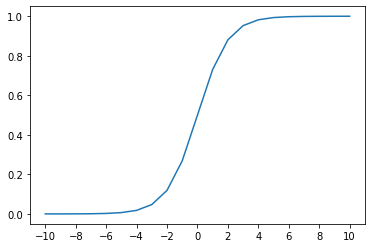

In [6]:
z=[1/(1+np.exp(-x)) for x in range(-10,11)]
plt.plot([x for x in range(-10,11)],z)
plt.xticks([t for t in range(-10,11,2)])
plt.show()

In [7]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s


## Learning

So how do we learn the __unknown__ conditional probability __p(y|x)__ of a given input image being a ship or not?
Note that we have already modeled our conditional probability as a sigmoid: $$\hat{p}_{w,b}(y=1|x)=\sigma_{w,b}(x)$$
and clearly 
$$\hat{p}_{w,b}(y=0|x)=1-\sigma_{w,b}(x)$$
Where we have explicitly showed the dependence of $\sigma$ on the weights $w$ and the bias $b$

We can combine both outcomes, and drop the subscripts for simplicity keeping in mind that $\sigma$ depends on both $w$ and $b$, to obtain our distribution
$$\hat{p}_{w,b}(y|x)=\sigma(x)^y(1-\sigma(x))^{1-y}$$

### Kullback-Leibler

To obtain our best model we use the Kullback-Leibler divergence formula (or relative entropy) to measure how close our distribution $\hat{p}$ is to the __true__ but __unknown__ distribution $p$

$$KL(p||\hat{p})=\sum_{x,y}p(y|x)\log\frac{p(y|x)}{\hat{p}(y|x)}=-\sum_{x,y}p(y|x)\log \hat{p}(y|x)+\sum_{x,y}p(y|x)\log p(y|x) >=0$$

Our goal is to obtain $\hat{p}$ as close as possible to $p$ so we minimize the KL. Since the second term does not depend on $w$ and $b$ we minimize the first term, or maximize its negative, i.e. __maximize the log-likelihood__
$$\mathbb{E}_{x,y\sim p}[\log \hat{p}(y|x)]$$

But since we don't have access to the __true__ __unknown__ distribution we replace the expectation with an expectation over the data. Let $D=\{(x_1,y_1),\ldots,(x_n,y_n)\}$ be our data set then
$$\mathbb{E}_{x,y\sim p}[\log \hat{p}(y|x)]\approx \frac{1}{|D|}\sum_{x,y\in D}\log \hat{p}(y|x)$$

In the current setting recall that $\hat{p}(y|x)=\sigma_w(w)^y(1-\sigma_w(x))^{1-y}$

Therefore we obtain the expression to be minimized
$$E=\frac{1}{|D|}\sum_{x,y\in D}y\cdot\sigma_w(x)+(1-y)\cdot(1-\sigma_w(x))$$

In what follows we will refer to the above expression for $E$ as the __error__



## Gradient Descent

Now that we have an expression to optimize we need a method to find the optimal parameters. Typically, one computes the gradient and the optimal value corresponds to the value  of the parameters when the gradient vanishes. Unfortunately, for logistic regression there is __no closed form solution__ so we seek a numerical method to find the optimal parameters.

Our goal is to find the **optimal** values for _W_ and _b_. To do so we give them some _arbitrary_ values and then using the expression for $E$
In the figure below we show an arbitrary function _E(w)_. For a given value of _w_ we compute the derivative (slope) of _E_ with respect to _w_ (two different values are shown). The point on the left side has a negative slope so we need to **increase** the value of _w_ to move toward the minimum whereas the point on the right side the slope is positive so we have to **decrease** the value of _w_. 

In general we "update" the values of _w_ and _b_ as follows

$$
\begin{align*}
  w=w-\alpha\cdot \frac{\partial E}{\partial w}\\
  b=b-\alpha\cdot \frac{\partial E}{\partial b}
\end{align*}
$$

where $\alpha$ is a parameter chosen by us, called the __learning rate__.


<center>
<img src="https://github.com/hikmatfarhat-ndu/CSC645/blob/master/figures/gradient-descent.png?raw=1" width="350">
</center>



## Gradient Descent for Logistic Regression

The first thing we need to do is compute the __derivatives__ of $E$ with respect to the parameters. 

Let $X$ and $Y$ be a sample image and its corresponding label. And let $\hat{p}$ be the probability that the outcome is $Y$ given input $X$ our __error__ function can be written as 

$$
\begin{align*}
E=-Y\log\hat{p}-(1-Y)\log (1-\hat{p})
\end{align*}
$$

Taking the derivative with respect to _w_ and _b_ we get

$$
\begin{align*}
dw &=\frac{\partial E}{\partial w}=X^T\cdot (\hat{p}-Y)/m\\
db &=\frac{\partial E}{\partial b}=\sum_{i=1}^{m}(\hat{p}_i-Y_i)/m
\end{align*}
$$

Where $T$ is the transpose, $\cdot$ is the dot product and $m$ is the number of samples. For details on the above **please refer to the pdf lecture notes**

In [8]:
# Perform forward propagation
# Then compute the cost and gradient
def propagate(w, b, X, Y):
# m is the number of samples which is the number of rows in X
    m = X.shape[0]
    p_hat= sigmoid(np.dot(X,w)+b)   # compute activation
    cost=-np.sum(Y*np.log(p_hat)+(1-Y)*np.log(1-p_hat))/m
    # Compute Derivatives
    dw = np.dot(X.T,(p_hat-Y))/m
    db = np.sum(p_hat-Y)/m
    cost = np.squeeze(cost)
    
    return dw, db, cost


In [9]:
def initialize(dim):
  # this sets the initial p_hat to 0.5
    w = np.zeros((dim,1))
    b = 0
    
    return w, b

In [10]:
learning_rate = 0.026
print_cost = True

    
# initialize parameters with zeros 
w, b = initialize(img_train.shape[1])
dw,db,cost=propagate(w,b,img_train,label_train)


## Parameter initialization

### Gradient Descent

A single step of gradient descent. Update parameters _w_ and _b_ 

In [11]:
def learn(w, b, X, Y, num_iterations,learning_rate, print_cost = False):
    
    for i in range(num_iterations):
        # Cost and gradient calculation 
        dw,db, cost = propagate(w,b,X,Y)
        
        # update rule
        w = w-learning_rate*dw
        b = b-learning_rate*db

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    
    return w,b,dw,db


In [12]:
w,b,dw,db= learn(w, b, img_train, label_train, 1,0.01, True)
print(w.shape)
print(dw.shape)

Cost after iteration 0: 0.693147
(3072, 1)
(3072, 1)


## Prediction

After we finish learning convert output >=0.5 to 1  (ship) and <0.5 to 0 (not ship)

In [18]:
def predict(w, b, X):
    
    m = X.shape[0]
    Y_prediction = np.zeros((m,1))
    
    # Compute vector "Y_hat" predicting
    #    the probabilities of a ship being present in the picture
    p_hat= sigmoid(np.dot(X,w)+b)   # compute activation


    for i in range(p_hat.shape[0]):
        
        # Convert probabilities Y_hat[0,i] to actual predictions p[0,i]
        if p_hat[i]>=0.5:
            Y_prediction[i]=1
        else:
            Y_prediction[i]=0
    

    return Y_prediction


## Main loop
Define the number of iterations and learning_rate then call gradient descent. After performing num_iterations of gradient descent we predict the type of all images including the ones in the test set and compare with the given labels to gauge the accuracy of our prediction.

In [19]:
num_iterations = 1000
learning_rate = 0.026
print_cost = True
# initialize parameters with zeros 
w, b = initialize(img_train.shape[1])

# Gradient descent 
w,b,dw,db= learn(w, b, img_train, label_train, num_iterations, learning_rate, print_cost)


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.278183
Cost after iteration 200: 0.274052
Cost after iteration 300: 0.271784
Cost after iteration 400: 0.269959
Cost after iteration 500: 0.268390
Cost after iteration 600: 0.266999
Cost after iteration 700: 0.265740
Cost after iteration 800: 0.264583
Cost after iteration 900: 0.263509
train accuracy:89.992
test accuracy:89.82


In [20]:


# Predict test/train set examples


Y_prediction_test = predict(w, b, img_test)
Y_prediction_train = predict(w, b, img_train)

# Print train/test Errors


print("train accuracy:"+str((100 - np.mean(np.abs(Y_prediction_train - label_train)) * 100)))
print("test accuracy:"+str((100 - np.mean(np.abs(Y_prediction_test - label_test)) * 100)))


train accuracy:89.992
test accuracy:89.82
